In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model

from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K

import os
import sys
sys.path.append("..")
# Seems to need models because of Lambda layer
from deepvideo import models

/home/caiafa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_dataset(base_path='../../UCF-101-dataset/ucfTrainTestlist',
                split_number=1,
                val_size=0.2,
                random_state=42):
    
    # Assert split is in valid range
    assert (split_number >= 1) and (split_number <= 3), \
    'Invalid split. Choose from 1, 2 or 3 folds.'
    
    # Get training data
    with open(base_path+'/trainlist{:02d}.txt'.format(split_number), 'r') as train_file:
        train_videos = []
        train_label = []
        for video in train_file:
            train, label = video.split(' ')
            train_videos.append(train.split('.')[0])
            train_label.append(video.split('/')[0])

    # Get test data
    with open(base_path+'/mod_testlist{:02d}.txt'.format(split_number), 'r') as test_file:
        test_videos = []
        test_label = []
        for video in test_file:
            test, label = video.split(' ')
            test_videos.append(test.split('.')[0])
            test_label.append(video.split('/')[0])
    
    X_train = train_videos 
    X_test = test_videos
    y_train = train_label
    y_test = test_label
    
    return (X_train, y_train), (X_test, y_test)

In [3]:
# Variables defining loaded model, layer from wich to extract activations,
# batch size followed by input shape, images folder, display size of activations,
# number of columns on display, preprocess type for normalizer, wether model uses flow and flow folder
saved_model = '/home/caiafa/tcc/video-classification/models/rgb/Inception/inception_rgb_1f_72.hdf5'
desired_layer = 95
in_shape_w_batch = (1,4,244,244,3)
base_diret = '../../UCF-101-dataset/UCF-101-jpeg/'
disp_size = (20,20)
n_columns = 8
preprocess_type = 'inception'
use_flow = False
flow_diret = '../../UCF-101-dataset/UCF-101-flow/'
(X_train, y_train), (X_test, y_test) = get_dataset()

In [4]:
def our_load_image(path, h, w):
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                img = img.convert('RGB')
                img = img.resize((w, h))
                return img

In [5]:
def each_video(base_diret, video_name, frame_shape):
    # Get selected video path
    video_path = os.path.join(base_diret, video_name)
    # Calculate number of frames in the whole video
    total_frames = len(os.listdir(video_path))
    # Choose a random base frame
#     base_idx = np.random.randint(0, total_frames - frame_shape[0]) + 1
    base_idx = (total_frames - frame_shape[0])//2 + 1
    # Read and return video/frame
    video = np.zeros((frame_shape))  
    for offset_idx in range(frame_shape[0]):
        frame_path = os.path.join(video_path, 
                                  'image_{:05d}.jpg'.format(base_idx+offset_idx))
        video[offset_idx] = our_load_image(frame_path, frame_shape[-3], frame_shape[-2])
    return video

In [6]:
def each_video_flow(base_diret, video_name, frame_shape):
    # Get selected video path
    video_path = os.path.join(base_diret, video_name)
    # Reference frame path
    ref_path = os.path.join('../../UCF-101-dataset/UCF-101-jpeg/', video_name)
    # Calculate number of frames in the whole video
    total_frames = len(os.listdir(video_path))
    # Choose a random base frame
    base_idx = np.random.randint(0, total_frames - frame_shape[-1]//3) + 1
    # Read and return video/frame
    video = np.zeros((frame_shape))  
    for offset_idx in range(frame_shape[-1]//3-1):
        frame_path = os.path.join(video_path, 
                                  'flow_{:05d}.png'.format(base_idx+offset_idx))
        video[:, :, 3*offset_idx:3*offset_idx+3] = our_load_image(frame_path, frame_shape[-3], frame_shape[-2])
    fref_path = os.path.join(ref_path, 'image_{:05d}.jpg'.format(base_idx+offset_idx//2+1))
    video[:, :, -3:] = our_load_image(fref_path, frame_shape[-3], frame_shape[-2])
    return video

In [7]:
def choose_normalizer(model_name, frames):
    if model_name == 'resnet':
        from tensorflow.python.keras.applications.resnet50 import preprocess_input
        return preprocess_input(frames)
    elif model_name == 'vgg':
        from tensorflow.python.keras.applications.vgg19 import preprocess_input
        return preprocess_input(frames)
    elif model_name == 'inception':
        from tensorflow.python.keras.applications.inception_v3 import preprocess_input
        return preprocess_input(frames)
    else:
        return frames/255

In [8]:
model = load_model(saved_model)

In [9]:
# model.summary()

In [10]:
# Truncated model
model2 = model.layers[desired_layer].output
model2 = Model(model.input, model2)

In [11]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 244, 244,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 244, 244, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 121, 121, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 121, 121, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [12]:
# Loading frames without augmentation into array
if use_flow:
    frames = np.zeros(in_shape_w_batch)
    for im in range(frames.shape[0]):
        video_ind = np.random.randint(0, len(X_test))
        video_name = X_test[video_ind]
        frames[im] = each_video_flow(flow_diret, video_name, frames.shape[1:])
    frames = choose_normalizer(preprocess_type, frames)
else:
    frames = np.zeros(in_shape_w_batch)
    for im in range(frames.shape[0]):
#         video_ind = np.random.randint(0, len(X_test))
        video_ind = 438
        video_name = X_test[video_ind]
        frames[im] = each_video(base_diret, video_name, frames.shape[1:])
    frames = choose_normalizer(preprocess_type, frames)

In [13]:
def show_activations(dims, activations, n_columns, figsize = (20,20)):
    if len(dims)<4:
        ola = plt.figure(figsize=figsize)
        n_rows = min(dims[-1]//n_columns+1,8)
        imgs = min(dims[-1],64)
        for i in range(imgs):
            plt.subplot(n_rows, n_columns, i+1)
            plt.imshow(activations[:,:,i])
        plt.show()
        ola.savefig('inception_act.png')
    else:
        for t in range(dims[0]):
            mds = plt.figure(figsize=figsize)
            n_rows = min(dims[-1]//n_columns+1,8)
            imgs = min(dims[-1],64)
            for i in range(imgs):
                plt.subplot(n_rows, n_columns, i+1)
                plt.imshow(activations[t,:,:,i])
                plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
                plt.tight_layout()
            plt.show()
            mds.savefig('inception_act_{:02}.png'.format(t+1))

In [23]:
# # Getting activations (use for conv3d)
# layer_activation = model2.predict_on_batch(frames)
# layer_activation = layer_activation/np.amax(layer_activation)

In [24]:
# Para fazer pra inception, in_shape_w_batch = 1,numero de "frames" resultantes no caso da conv3d,244,244,3;
# na parte de pegar ativações frames[:,n,:,:,:], onde n corresponde ao "frame" da conv 3d, 0 1 2...; salvar e mudar o nome

In [17]:
# Getting multiple frame activations (use for single frame models)
layer_activation = []
for t in range(frames.shape[1]):
    mds = np.zeros((1,1,244,244,3))
    mds[0,0,:,:,:] = frames[:,t,:,:,:]
    layer_activation1 = model2.predict_on_batch(mds)
    layer_activation1 = layer_activation1/np.amax(layer_activation1)
    layer_activation.append(layer_activation1)

layer_activation = np.asarray(layer_activation)
layer_activation = layer_activation.transpose(1,0,2,3,4)

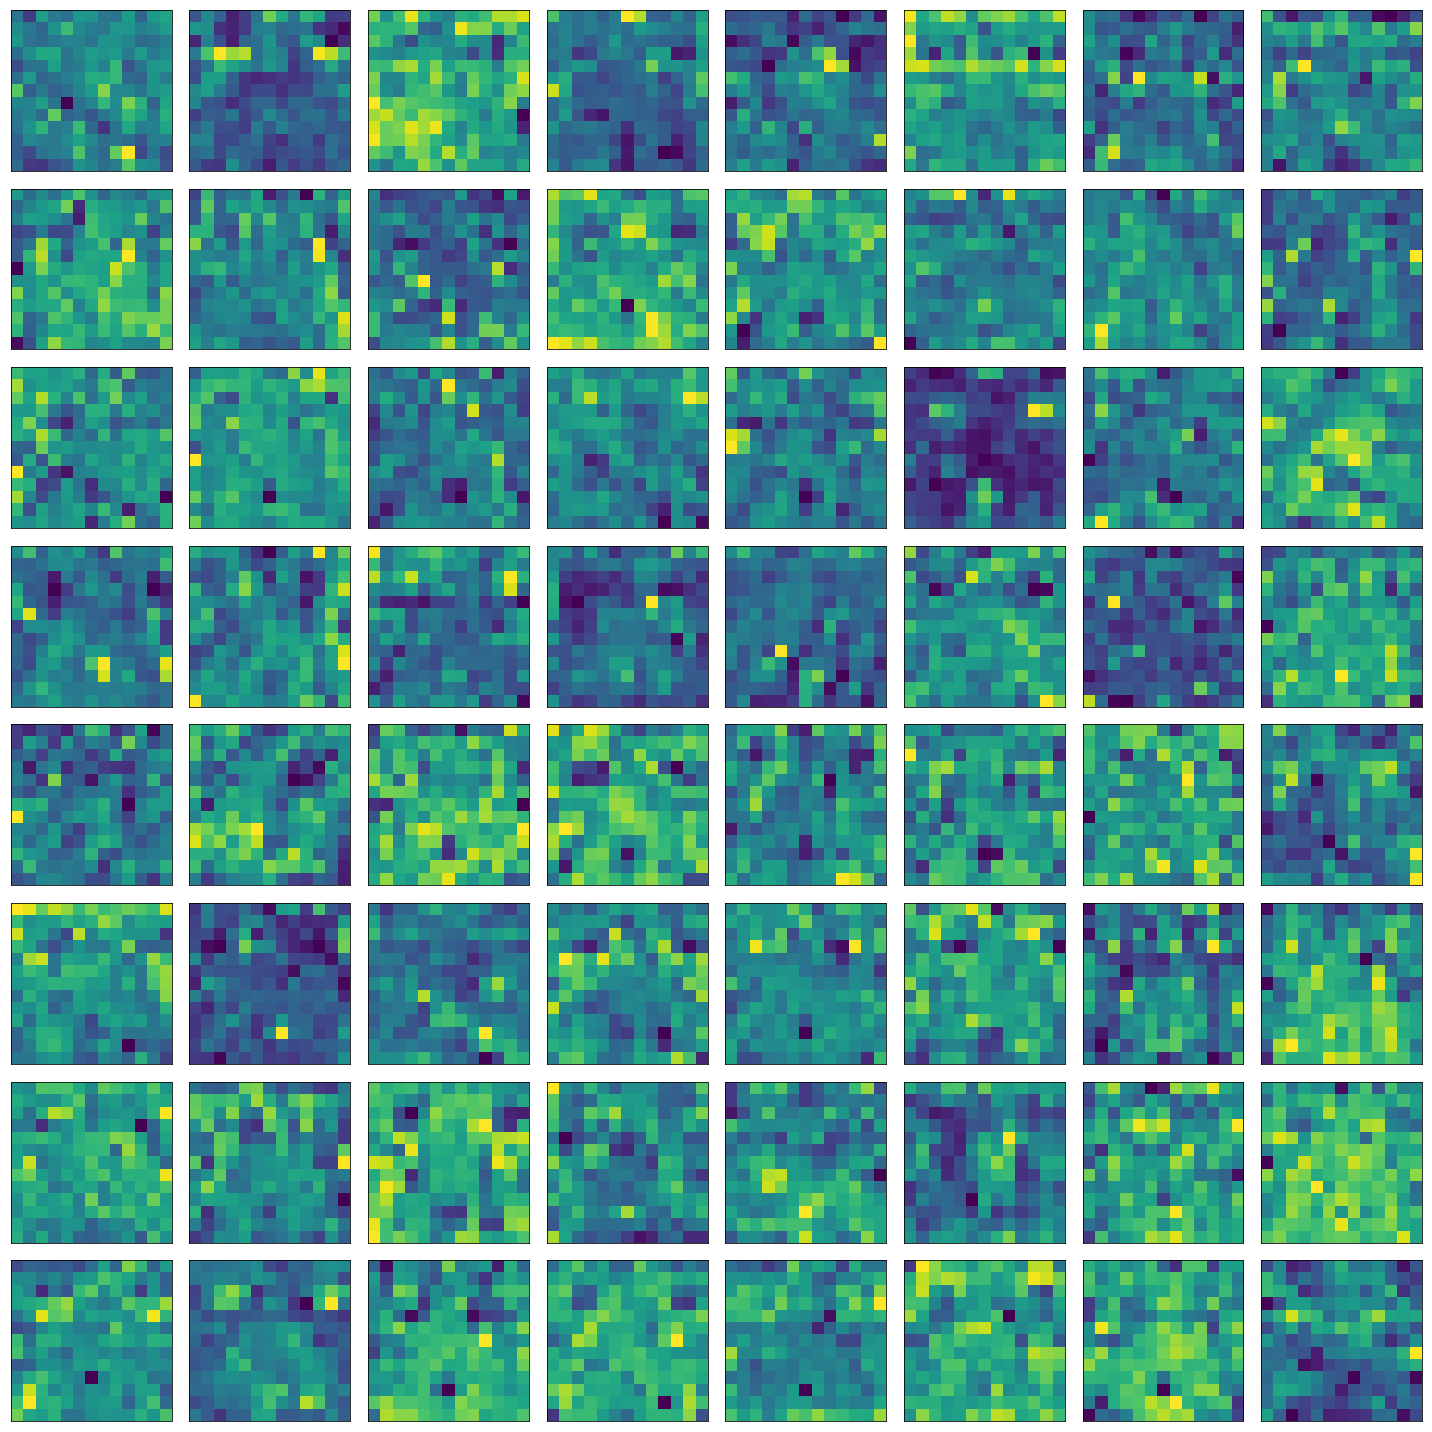

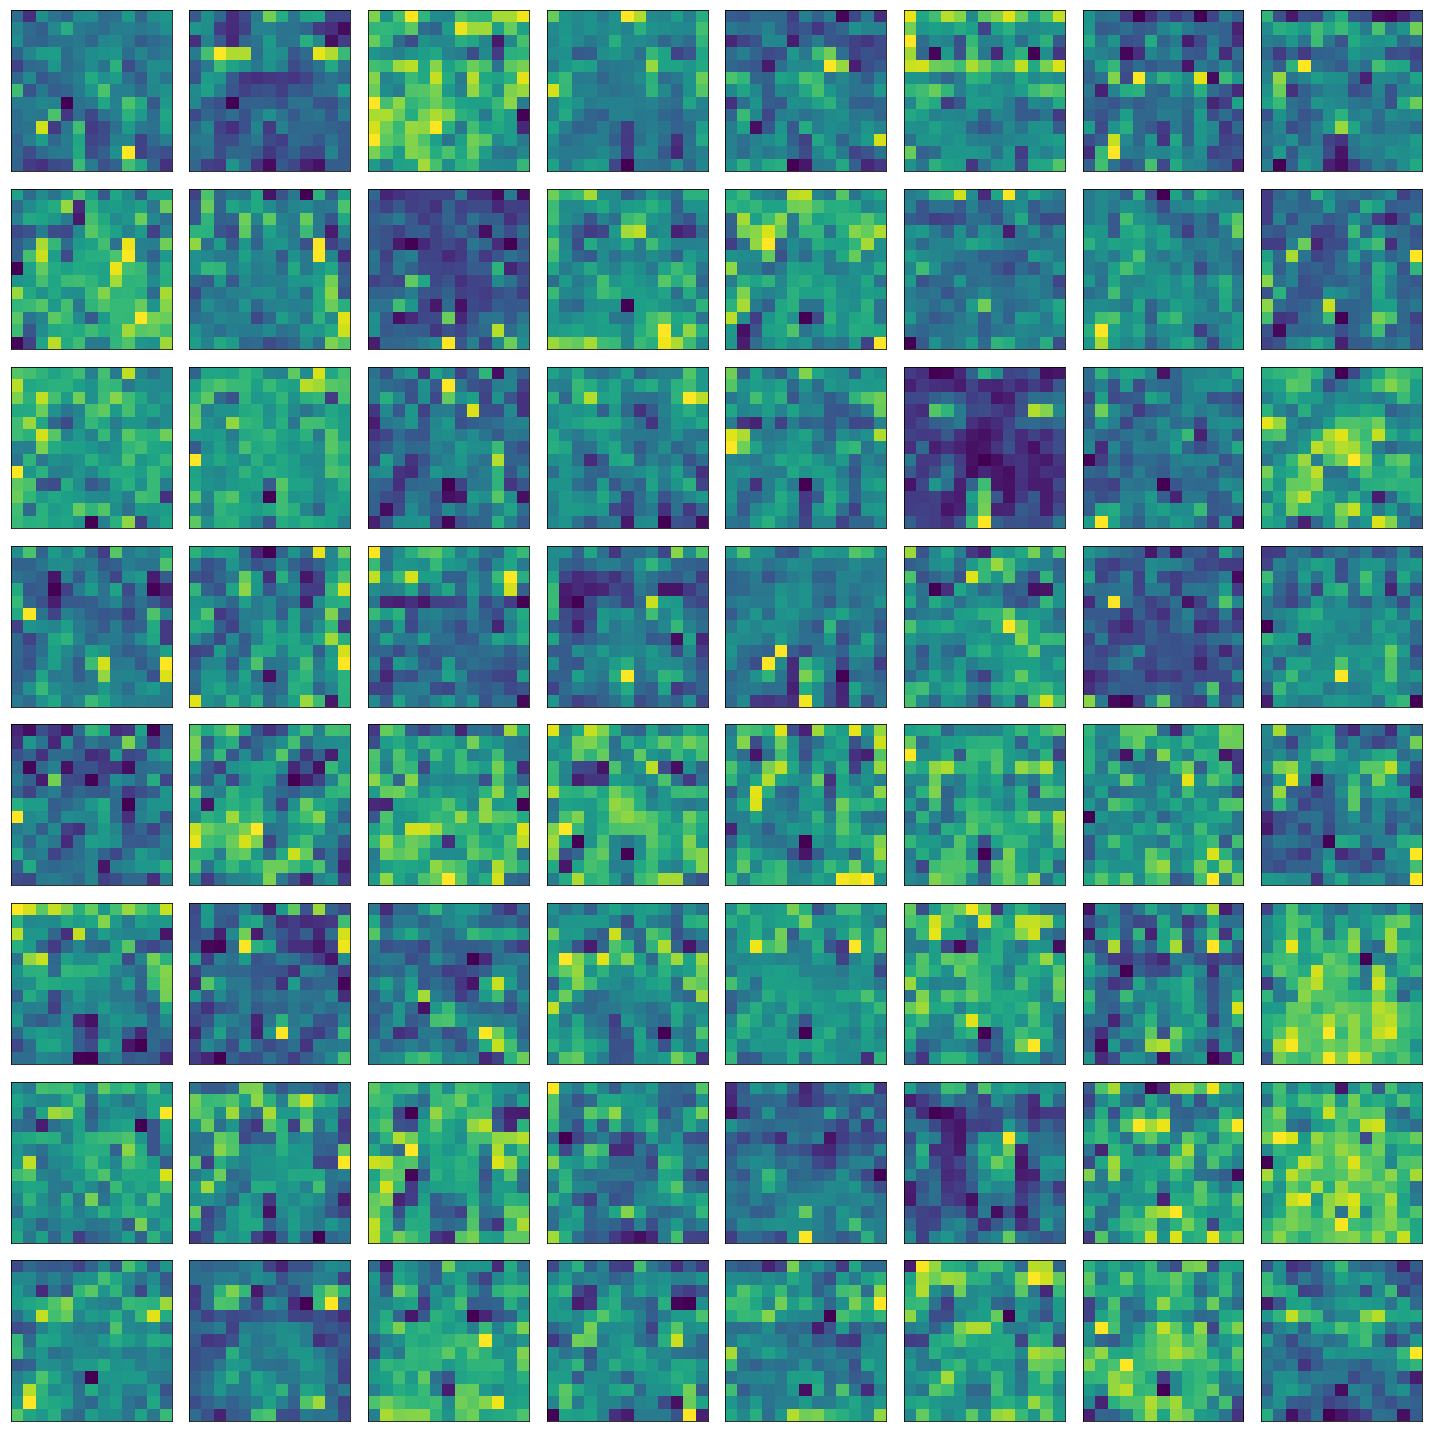

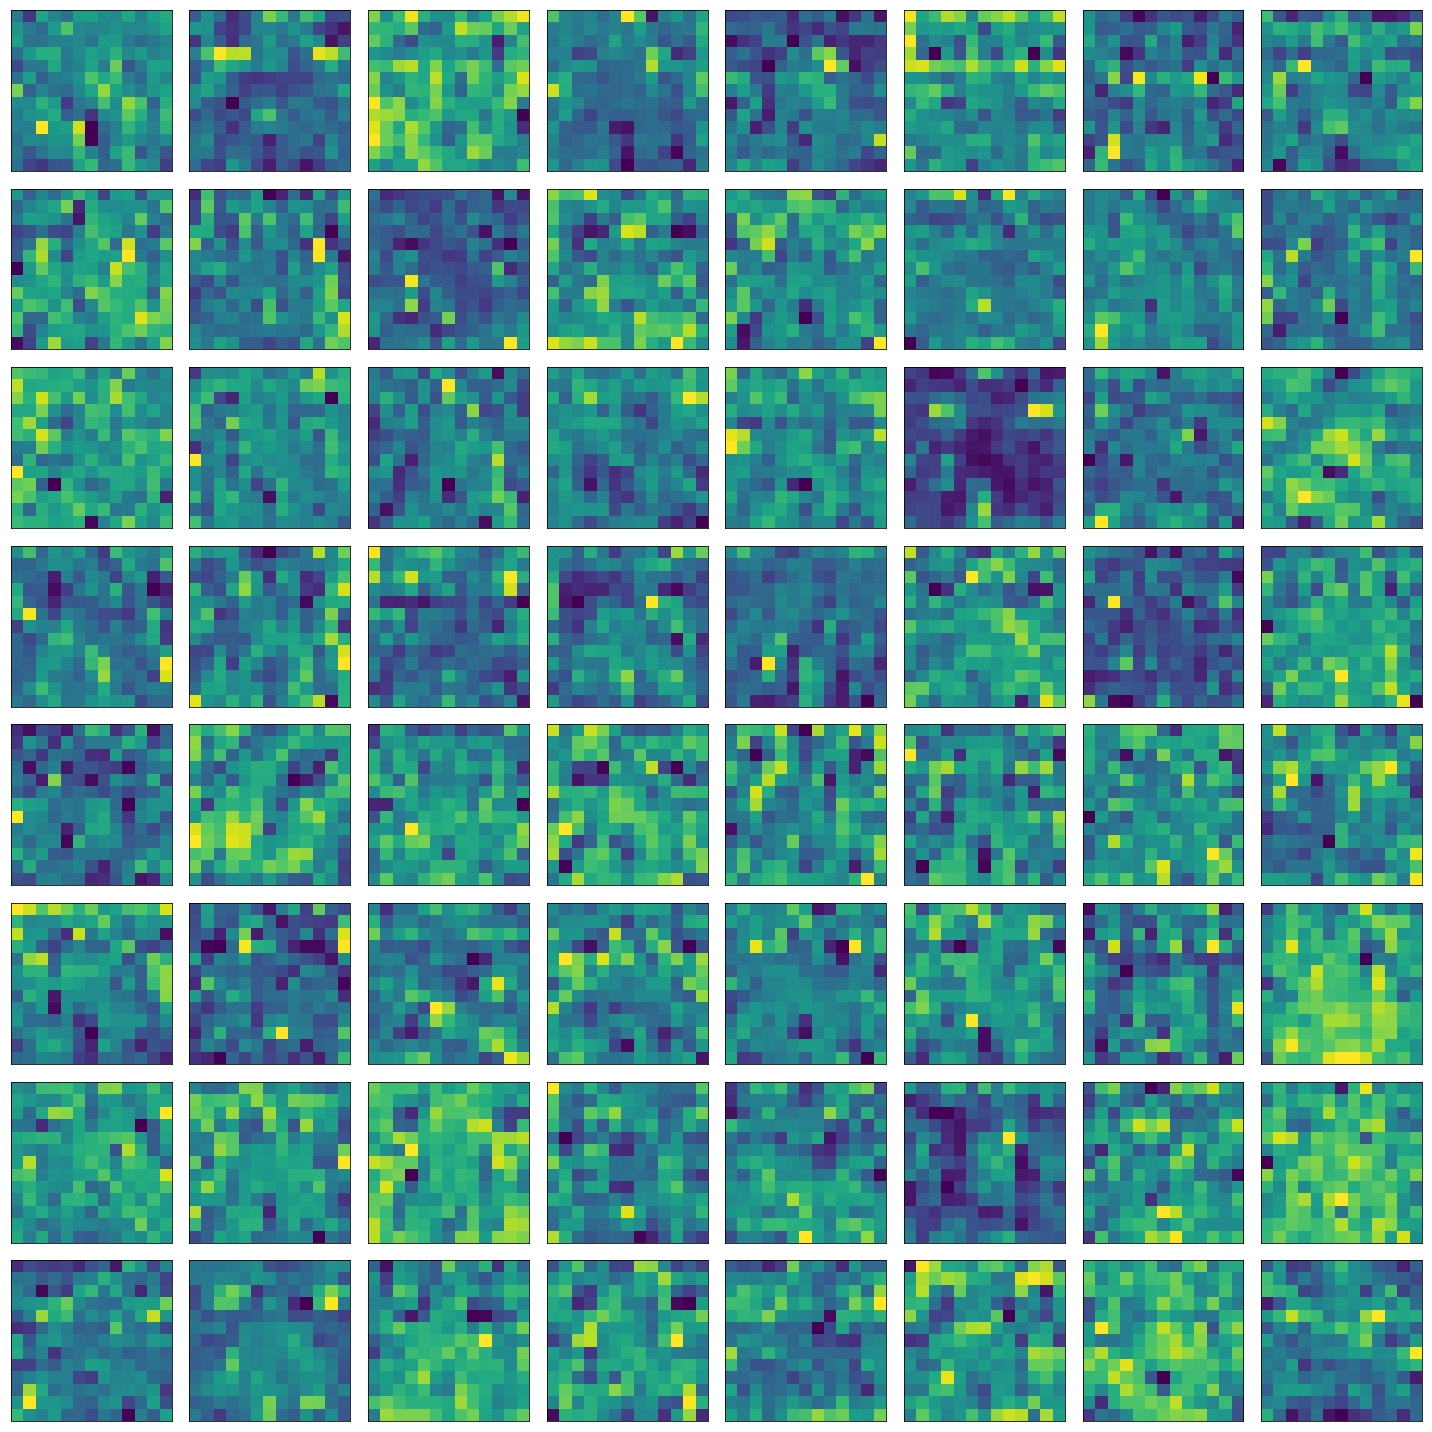

In [18]:
# Plot
show_activations(dims=layer_activation.shape[1:], activations=layer_activation[0], n_columns=n_columns, figsize=disp_size)

In [27]:
oi = plt.figure(figsize=(8,8))
plt.imshow(frames[0,0,:,:,:])
plt.show()
oi.savefig('ref_act.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [19]:
video_name

'Billiards/v_Billiards_g02_c06'